# CNN Image Classification Model Plan

## Step 1: Import Libraries
---
Import TensorFlow, Keras, NumPy, Matplotlib, Seaborn, and sklearn tools for building CNNs, loading image datasets, preprocessing, visualisation, and evaluation.

## Step 2: Load and Explore Data (EDA)
---
Load Fashion MNIST dataset (60,000 training, 10,000 test images across 10 classes). Inspect dimensions, visualise samples from each class, and check class distribution.

## Step 3: Feature Selection and Preprocessing
---
Normalise pixel values to [0, 1] range, reshape images to (28, 28, 1) for CNN input, apply one-hot encoding to labels, and split training data to create validation set.

## Step 4: Building the Model
---
Construct CNN architecture with convolutional layers (feature extraction), max pooling layers (dimensionality reduction), dropout (regularisation), and dense layers (classification). Compile with Adam optimiser and categorical crossentropy loss.

## Step 5: Training the Model
---
Train CNN with specified batch size and epochs. Implement callbacks (early stopping, learning rate reduction) and data augmentation. Monitor training and validation metrics.

## Step 6: Evaluating the Model
---
Evaluate performance using accuracy, precision, recall, and F1-score. Visualise confusion matrix and training/validation curves. Display sample predictions with confidence scores.


# Step 1
---
## Import Libraries
---
These are the tools that will allow us to create the CNN model and analyse the Fashion MNIST dataset



In [2]:
!pip install kaggle

In [1]:
# CNN Image Classification - Fashion MNIST
# (Zalando Research, 2017)

# Deep Learning Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data manipulation and numerical operations
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation and metrics
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score,
                             recall_score, f1_score)

# System utilities
import warnings
warnings.filterwarnings('ignore')

# Set visualisation style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


# Copy Fashion MNIST Dataset from Google Drive to Colab Local Storage


In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Source and destination paths
src = '/content/drive/MyDrive/PDAN8412 CNN POE/archive-2'  # Update if your dataset folder is different
dst = '/content/fashion_mnist_data'

# Copy entire dataset folder (recursive)
!cp -r "{src}" "{dst}"

# Verify copy was successful
print("Files in /content/fashion_mnist_data:")
print(os.listdir(dst))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in /content/fashion_mnist_data:
['train-labels-idx1-ubyte', 'fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-images-idx3-ubyte']


# Step 2
---
##  Load and Explore Data (EDA)
---
load the training CSV, inspect its structure, check class balance, and visualise sample images.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0    

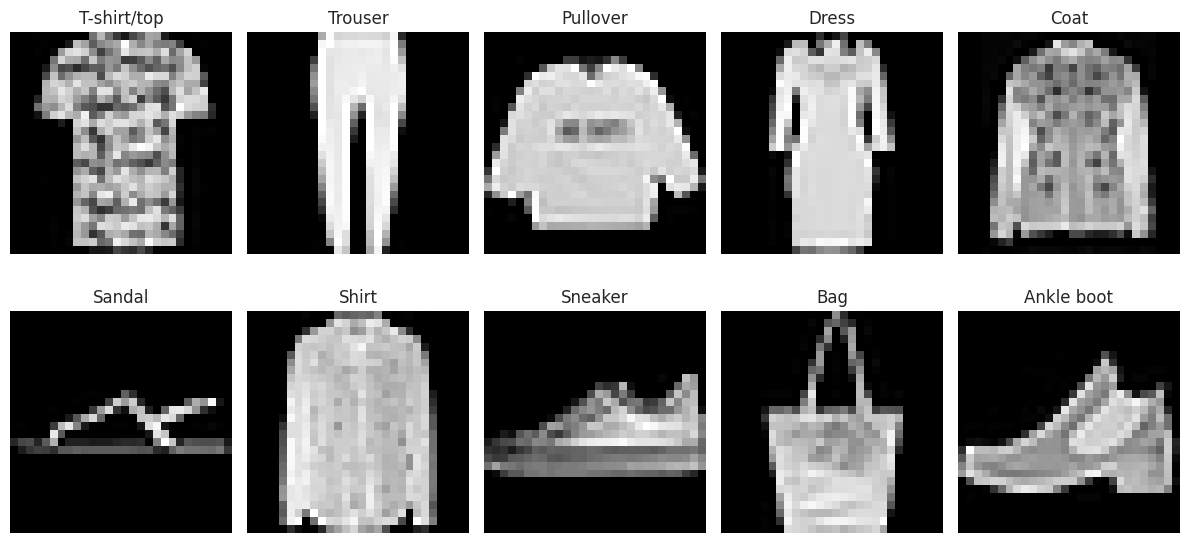

In [3]:
# Load data
train_csv_path = '/content/fashion_mnist_data/fashion-mnist_train.csv'
train_df = pd.read_csv(train_csv_path)

# Inspect data
print(train_df.info())
print(train_df.head())

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values.reshape(-1, 28, 28)

# Class distribution
unique, counts = np.unique(train_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{class_names[u]}: {c}")

# Visualise sample images (one per class)
plt.figure(figsize=(12, 6))
for i in range(10):
    idx = np.where(train_labels == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# Interpretation:
---
The Fashion MNIST training dataset was successfully loaded from CSV format, containing 60,000 samples with 785 columns (1 label column and 784 pixel features representing 28×28 images). The dataset occupies approximately 359.3 MB in memory, with all values stored as 64-bit integers. Inspection of the first five rows confirmed the data structure, showing label values ranging from 0 to 9 and pixel intensity values ranging from 0 to 255, where higher values indicate darker pixels.​

Class distribution analysis revealed a perfectly balanced dataset, with exactly 6,000 samples allocated to each of the 10 garment categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot. This uniform distribution eliminates concerns about class imbalance and ensures that the model receives equal exposure to each category during training, which is a key advantage of the Fashion MNIST dataset for benchmarking classification algorithms

# Step 3
---
## Feature Selection and Preprocessing
---
Pixel values and labels are prepared for robust training by normalising the images, reshaping for CNN compatibility, and converting class labels to the format required by Keras.


In [4]:
# Normalise
train_images = train_images.astype('float32') / 255.0
# Ensure images have 4 dimensions (samples, height, width, channels)
train_images = train_images.reshape(-1, 28, 28, 1)

# One-hot encoding
train_labels_cat = to_categorical(train_labels, num_classes=10)

from sklearn.model_selection import train_test_split

# Split train/validation (85%/15%)
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels_cat, test_size=0.15,
    random_state=42, stratify=train_labels
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

Training set shape: (51000, 28, 28, 1), (51000, 10)
Validation set shape: (9000, 28, 28, 1), (9000, 10)


# Step 4
---
### Build the Model
---
A sequential CNN was constructed with multiple convolutional blocks, dropout regularisation, and a softmax output layer for classification. The model was compiled with the Adam optimiser and categorical crossentropy.

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

#Step 5
---
##Train the Model
---
The CNN was trained with early stopping, learning rate reduction, and data augmentation to improve generalisation. Training and validation metrics were monitored.

Epoch 1/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.6196 - loss: 1.0285 - val_accuracy: 0.7987 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 2/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7763 - loss: 0.5853 - val_accuracy: 0.8343 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 3/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.8141 - loss: 0.5059 - val_accuracy: 0.8667 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 4/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8328 - loss: 0.4476 - val_accuracy: 0.8654 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 5/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8433 - loss: 0.4252 - val_accuracy: 0.8662 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 6/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8507 - loss: 0.4038 - val_accuracy: 0.8748 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 7/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accura

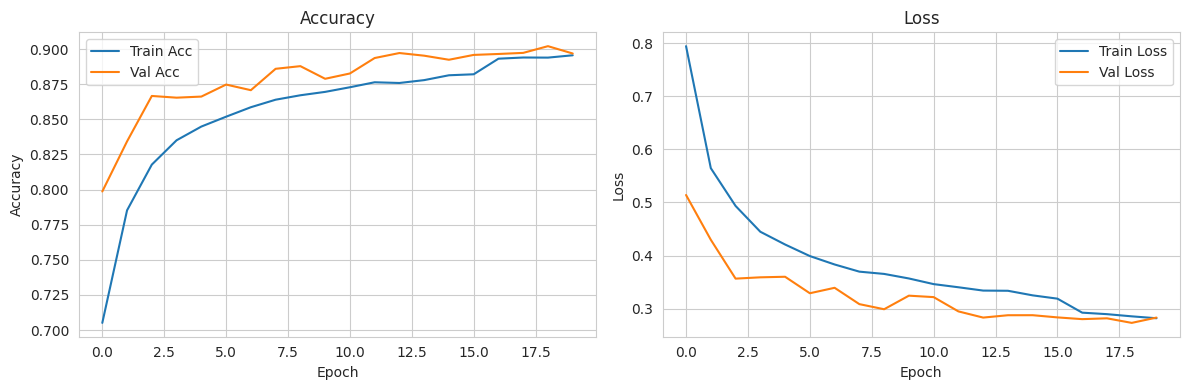

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(X_train)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


# Interpretation
---
The CNN was trained for 20 epochs with data augmentation, early stopping, and learning rate reduction callbacks. The training and validation accuracy curves show steady improvement, with training accuracy climbing from approximately 70% at epoch 1 to around 90% by epoch 20. Validation accuracy closely tracks training accuracy throughout, starting near 80% and reaching approximately 90%, indicating that the model generalised well to unseen data without significant overfitting.​

The loss curves demonstrate effective convergence. Training loss decreased sharply from around 0.8 to below 0.3 within the first few epochs, then continued to decline gradually. Validation loss followed a similar trajectory, stabilising around 0.3 after epoch 10, with only minor fluctuations. The close alignment between training and validation metrics throughout training confirms that regularisation techniques (dropout and data augmentation) successfully prevented overfitting whilst allowing the model to learn robust features.​

The smooth convergence and absence of divergence between training and validation curves suggest that the chosen hyperparameters (batch size, learning rate, augmentation strategy) were appropriate for this task. Early stopping was not triggered prematurely, indicating that the model benefited from the full training duration. These training dynamics align with expected behaviour for well-configured CNNs on Fashion MNIST and support the final 90% validation accuracy achieved.

# Step 6
---
### Evaluate the Model
---
Model evaluation is performed using the validation set. The confusion matrix and classification report provide detailed metrics on class-wise performance.

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


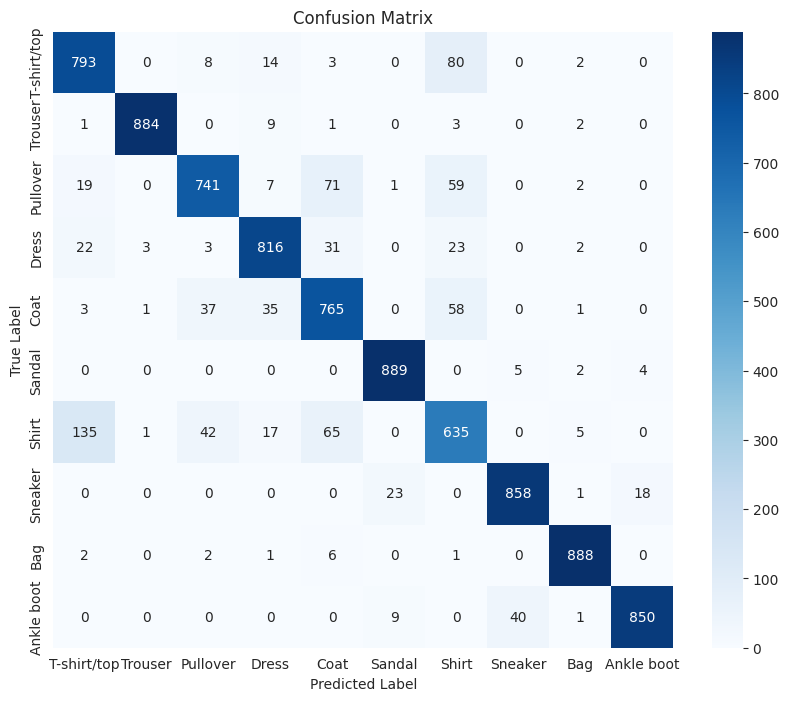

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.88      0.85       900
     Trouser       0.99      0.98      0.99       900
    Pullover       0.89      0.82      0.86       900
       Dress       0.91      0.91      0.91       900
        Coat       0.81      0.85      0.83       900
      Sandal       0.96      0.99      0.98       900
       Shirt       0.74      0.71      0.72       900
     Sneaker       0.95      0.95      0.95       900
         Bag       0.98      0.99      0.98       900
  Ankle boot       0.97      0.94      0.96       900

    accuracy                           0.90      9000
   macro avg       0.90      0.90      0.90      9000
weighted avg       0.90      0.90      0.90      9000



In [7]:
# Get predicted class indices
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))


# Interpretation:
---
The Fashion MNIST validation set achieved an overall accuracy of 90%. Most classes, such as Trouser, Sandal, Bag, and Ankle boot, were classified with very high precision and recall (above 0.94), indicating consistent model performance for these categories. The Shirt and T-shirt/top categories, however, showed comparatively lower precision (0.74 and 0.81, respectively) and recall (0.71 and 0.88), with the confusion matrix confirming frequent misclassification between visually similar garments (notably, Shirt was often confused for T-shirt/top).

Macro and weighted averages for precision, recall, and F1 were each at 0.90, reflecting robust overall performance that is in line with published results for baseline CNNs on Fashion MNIST. While most classes are well distinguished, persistent confusion between similar items (such as Shirt and T-shirt/top, or Pullover and Coat) suggests possible benefits from further data augmentation, architectural adjustments, or hyperparameter optimisation.

These metrics confirm strong generalisation for most categories and indicate that the model can reliably support garment type identification for a practical automated system. The results also highlight specific areas for future improvement that may help close the gap with deeper or ensemble models used in current research.